<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/autoenncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Deep Autoencoders
By [Fayyaz Minhas](https://sites.google.com/view/fayyaz/home)

In this tutorial, we embark on an exploratory journey through the fascinating world of autoencoders, using the PyTorch library. Autoencoders are a class of neural networks designed for unsupervised learning tasks, primarily for dimensionality reduction and feature learning. At their core, autoencoders learn to compress (encode) data into a lower-dimensional space and then reconstruct (decode) it back to its original form. This characteristic makes them exceptionally useful for tasks like anomaly detection, denoising, and, more generally, learning efficient representations of data.

Our focus will be on implementing a deep autoencoder to work with the MNIST dataset, a collection of 70,000 handwritten digits commonly used for training various image processing systems. The MNIST dataset provides a straightforward yet challenging sandbox for our autoencoder model, allowing us to dive deep into the intricacies of neural network training and optimization.

We will start by setting up our environment, including the necessary imports from PyTorch, datasets for our MNIST data, and additional libraries for data manipulation and visualization. Following this, we'll delve into the data preprocessing phase, where we'll apply transformations to our dataset, including flattening the images and mean-centering our data. Mean-centering is crucial for neural network efficiency as it helps in faster convergence by ensuring that the mean of each dimension across our data is zero.

After preparing our data, we will define our autoencoder's architecture. Our model will be a deep autoencoder, consisting of an encoder that compresses the data into a two-dimensional latent space and a decoder that reconstructs the data from this compressed form. The architecture choice is deliberate to showcase the model's ability to reduce dimensionality significantly while still capturing the essential features required for reconstruction.

Once our model is defined, we proceed to the training phase. Here, we'll employ a training loop that iteratively updates our model's weights to minimize the reconstruction error, measured by the mean squared error (MSE) between the original and reconstructed images. This process will highlight the importance of optimization algorithms and loss functions in the training of neural networks.

To cap off our exploration, we will leverage our trained autoencoder to generate a 2D scatter plot of the encoder outputs for the test set, colored by their class ID. This visualization will not only allow us to inspect the learned representations but also gauge how well our model can cluster and separate different classes in a reduced-dimensional space, providing insights into the model's effectiveness and the quality of the learned embeddings.



Epoch: 1 [0/60000 (0%)]	Loss: 0.066640
Epoch: 1 [6400/60000 (11%)]	Loss: 0.044606
Epoch: 1 [12800/60000 (21%)]	Loss: 0.046044
Epoch: 1 [19200/60000 (32%)]	Loss: 0.042795
Epoch: 1 [25600/60000 (43%)]	Loss: 0.043512
Epoch: 1 [32000/60000 (53%)]	Loss: 0.039960
Epoch: 1 [38400/60000 (64%)]	Loss: 0.043619
Epoch: 1 [44800/60000 (75%)]	Loss: 0.042453
Epoch: 1 [51200/60000 (85%)]	Loss: 0.039481
Epoch: 1 [57600/60000 (96%)]	Loss: 0.044478
Epoch: 2 [0/60000 (0%)]	Loss: 0.042015
Epoch: 2 [6400/60000 (11%)]	Loss: 0.038583
Epoch: 2 [12800/60000 (21%)]	Loss: 0.036638
Epoch: 2 [19200/60000 (32%)]	Loss: 0.040320
Epoch: 2 [25600/60000 (43%)]	Loss: 0.041283
Epoch: 2 [32000/60000 (53%)]	Loss: 0.036645
Epoch: 2 [38400/60000 (64%)]	Loss: 0.040981
Epoch: 2 [44800/60000 (75%)]	Loss: 0.039172
Epoch: 2 [51200/60000 (85%)]	Loss: 0.035716
Epoch: 2 [57600/60000 (96%)]	Loss: 0.038690
Epoch: 3 [0/60000 (0%)]	Loss: 0.038396
Epoch: 3 [6400/60000 (11%)]	Loss: 0.040577
Epoch: 3 [12800/60000 (21%)]	Loss: 0.038796
Epoch:

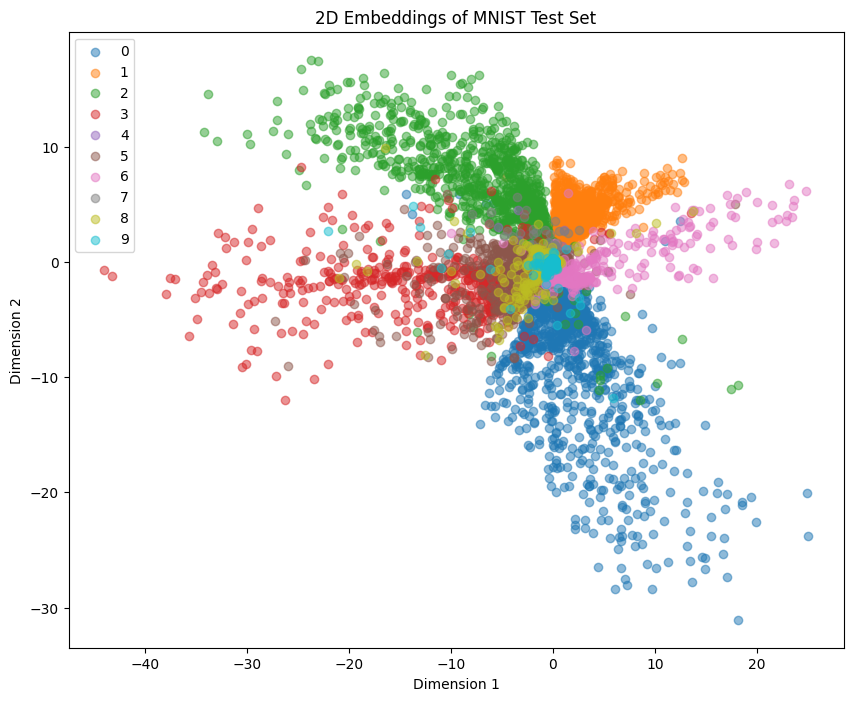

In [5]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Determine if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Download and Preprocess the Data
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: torch.flatten(x)])

# Load datasets without applying mean-centering yet
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Calculate the global mean across all training data
train_loader_for_mean = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
data, _ = next(iter(train_loader_for_mean))
global_mean = data.mean(dim=0)

# Apply mean-centering
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: torch.flatten(x) - global_mean])

train_dataset.transform = transform
test_dataset.transform = transform

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Define the Autoencoder Architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
            #nn.Sigmoid() # Use sigmoid to ensure output is between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 3. Training Loop
def train(epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Training the model
for epoch in range(1, 6):  # Training for 5 epochs for demonstration
    train(epoch)

# 4. Generate a 2D scatter plot of the encoder output
def plot_2d_embedding(test_loader, model):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            embeddings.append(model.encoder(data).cpu().numpy())
            labels.append(target.numpy())

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    plt.figure(figsize=(10, 8))
    for i in range(10):  # There are 10 classes in MNIST
        idxs = labels == i
        plt.scatter(embeddings[idxs, 0], embeddings[idxs, 1], label=str(i), alpha=0.5)
    plt.legend()
    plt.title('2D Embeddings of MNIST Test Set')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

plot_2d_embedding(test_loader, model)


## Reconstruction

In understanding and implementing autoencoders, a crucial milestone is the ability to visually compare the original input data with its reconstructed version after being processed by the autoencoder. This comparison not only allows us to assess the performance of our model in a qualitative manner but also provides insights into what features the model is capturing and what details might be lost or altered during the encoding and decoding processes.

The following code segment is designed to demonstrate this aspect of working with autoencoders. After training our model on the MNIST dataset, we'll select a batch of test images to pass through our trained autoencoder. The goal here is to observe how well our model can reconstruct the original digits after compressing them into a lower-dimensional space and then expanding them back to their original dimensionality.

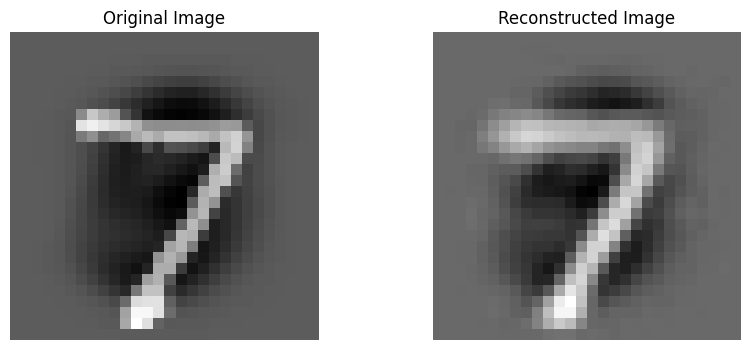

In [13]:
  model.eval()
  # Obtain one batch of test images
  data, _ = next(iter(test_loader))
  data = data.to(device)
  # Forward pass through the network
  with torch.no_grad():
      encoded = model.encoder(data)
      output = model.decoder(encoded)
  # Move the data back to CPU for visualization
  data = data.cpu()
  output = output.cpu()

  # Convert the first image in the batch from PyTorch tensor to NumPy array
  original_img = data[0].view(28, 28).numpy()
  reconstructed_img = output[0].view(28, 28).numpy()

  # Display the original and reconstructed images
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))
  axes[0].imshow(original_img, cmap='gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off')

  axes[1].imshow(reconstructed_img, cmap='gray')
  axes[1].set_title('Reconstructed Image')
  axes[1].axis('off')

  plt.show()

## Generative Modeling with Autoencoders

Autoencoders, renowned for their data compression and feature learning capabilities, also unlock fascinating generative possibilities. By manipulating the encoded representations of data within the latent space, we can generate new, unseen images that mirror the characteristics of the training dataset. This approach leverages the principle that slight perturbations in the latent space can lead to meaningful variations in the output space, allowing the autoencoder to function as a simple generative model.

The provided code illustrates this generative capacity by first encoding a batch of images, then intentionally perturbing these encoded vectors with random noise, and finally decoding them. The result is a set of generated images that, while derived from the original data, exhibit new features and variations. This experiment not only demonstrates the autoencoder's ability to create novel content but also serves as a stepping stone towards more sophisticated generative models.

Through this concise exploration, we aim to visualize the transformative journey from encoding, through latent space perturbation, to the generation of new images, shedding light on the latent space's pivotal role in bridging compression and creation.

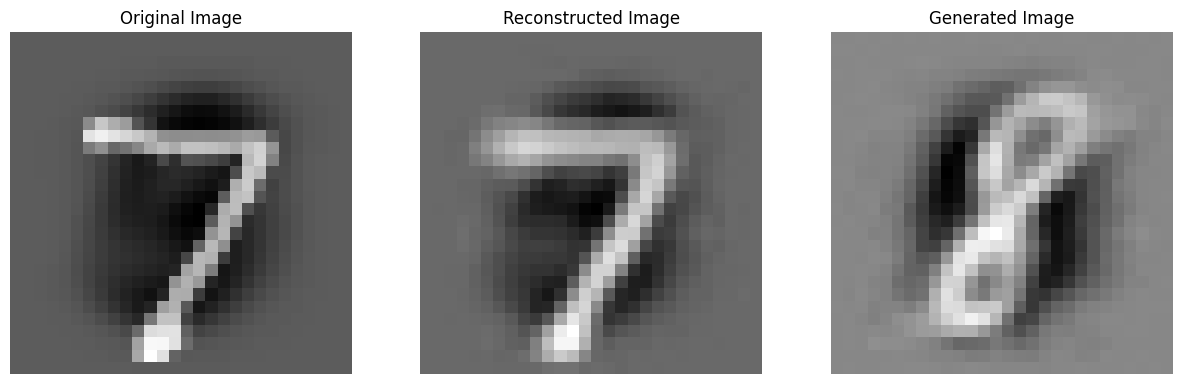

In [14]:
model.eval()
# Obtain one batch of test images
data, _ = next(iter(test_loader))
data = data.to(device)
# Forward pass through the network
with torch.no_grad():
    encoded = model.encoder(data)

    # Perturb the encoding
    # For simplicity, we add random noise. Adjust the magnitude as needed.
    noise = torch.randn_like(encoded) * 0.5  # Adjust the 0.5 to control perturbation magnitude
    perturbed_encoded = encoded + noise

    # Decode the original and perturbed encodings
    output = model.decoder(encoded)
    perturbed_output = model.decoder(perturbed_encoded)

# Move the data back to CPU for visualization
data = data.cpu()
output = output.cpu()
perturbed_output = perturbed_output.cpu()

# Convert the first image in the batch from PyTorch tensor to NumPy array
original_img = data[0].view(28, 28).numpy()
reconstructed_img = output[0].view(28, 28).numpy()
generated_img = perturbed_output[0].view(28, 28).numpy()

# Display the original, reconstructed, and generated images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_img, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

axes[2].imshow(generated_img, cmap='gray')
axes[2].set_title('Generated Image')
axes[2].axis('off')

plt.show()


## Advanced Autoencoders:

There are different flavors of autoencoders starting from the vanilla auto-encoder we have just coded.

1. Vanilla Auto-encoder

* Functionality: A Vanilla Auto-encoder consists of an encoder and a decoder. The encoder compresses the input into a latent-space representation (encoding), and the decoder reconstructs the input data from this latent representation. The goal is to minimize the reconstruction error, encouraging the autoencoder to learn useful features in an unsupervised manner.

* It's the simplest form of autoencoder with a straightforward architecture.
Unlike its more advanced variants, it doesn't explicitly force the latent space to follow a particular distribution, making it less effective for generating new data.
2. Denoising Auto-encoders (DAE)
* Functionality: Denoising Auto-encoders extend Vanilla Auto-encoders by training to reconstruct the original input from a corrupted version of it. This corruption could be random noise added to the input data. The goal is to force the encoder to learn more robust features and ignore the "noise" in the input data.
* DAEs are better at learning robust features compared to Vanilla Auto-encoders because they have to recover the original signal from a corrupted input.
They are more resilient to overfitting on the training data.
3. Variational Auto-encoder (VAE)
* Functionality: VAEs introduce a probabilistic twist to the encoding process. Instead of encoding an input as a single point, a VAE encodes it as a distribution over the latent space. This approach allows for the generation of new data by sampling from the latent space.
* VAEs are explicitly designed to learn the probability distribution of the data, making them suitable for generative tasks.
They enforce a continuous, structured latent space, allowing for smooth interpolation and generation of new instances.
Compared to Vanilla and Denoising Auto-encoders, VAEs can generate new data but might result in less sharp reconstructions due to the probabilistic nature of their output.
4. Vector-Quantized Variational Autoencoder (VQ-VAE)
* Functionality: VQ-VAE combines ideas from VAEs and vector quantization. It uses a discrete latent representation instead of a continuous one. The encoder maps inputs to a discrete latent space by finding the nearest vector in a predefined set of vectors (codebook). The decoder then reconstructs the input from these quantized vectors.
* VQ-VAE can generate high-quality, diverse samples and is particularly useful for tasks requiring discrete representations, like in natural language processing or discrete data generation.
* It addresses some limitations of VAEs by enabling the learning of a more structured latent space with discrete rather than continuous variables, potentially improving the interpretability and control over generated data.
* The quantization step introduces a non-differentiability issue, which is handled through a technique called "straight-through estimator," making the training process more complex than that of standard VAEs.
### Comparison:
Each type of autoencoder has its unique strengths and is suited for different applications. Vanilla Auto-encoders are great for simple dimensionality reduction tasks. Denoising Auto-encoders excel in learning robust features. VAEs are well-suited for generative tasks and modeling complex distributions, while VQ-VAEs offer advantages in scenarios where a discrete representation is preferable, offering a blend of high-quality generation capabilities with structured, interpretable latent spaces.